In [ ]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 224, 224, 3)
[1 0 0 1 1 0 0 1]


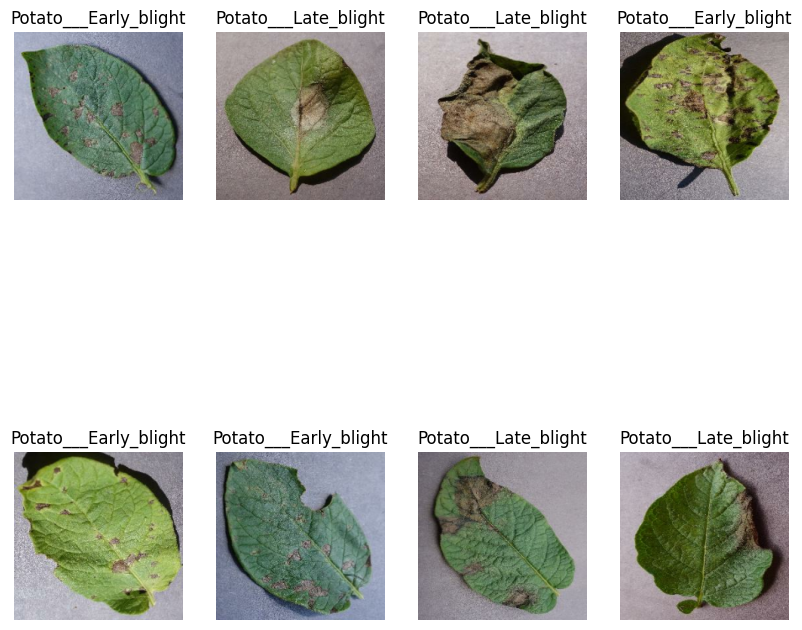

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

375

In [ ]:
train_size = 0.8
len(dataset)*train_size

300.0

In [ ]:
train_ds = dataset.take(300)
len(train_ds)

300

In [ ]:
test_ds = dataset.skip(300)
len(test_ds)

75

In [ ]:
val_size=0.1
len(dataset)*val_size

37.5

In [ ]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [ ]:
test_ds = test_ds.skip(37)
len(test_ds)

38

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  300
Validation Dataset Size:  37
Test Dataset Size:  38


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [ ]:
from tensorflow.keras.applications import DenseNet121

IMAGE_SIZE = 224
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = True

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                      

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
300/300 [==============================] - 147s 381ms/step - loss: 0.4210 - accuracy: 0.8525 - val_loss: 1.3773 - val_accuracy: 0.6622
Epoch 2/50
300/300 [==============================] - 109s 365ms/step - loss: 0.2099 - accuracy: 0.9296 - val_loss: 5.6178 - val_accuracy: 0.6554
Epoch 3/50
300/300 [==============================] - 110s 366ms/step - loss: 0.1419 - accuracy: 0.9496 - val_loss: 0.8900 - val_accuracy: 0.7838
Epoch 4/50
300/300 [==============================] - 115s 385ms/step - loss: 0.1218 - accuracy: 0.9563 - val_loss: 0.2599 - val_accuracy: 0.8885
Epoch 5/50
300/300 [==============================] - 116s 386ms/step - loss: 0.1165 - accuracy: 0.9642 - val_loss: 0.9472 - val_accuracy: 0.7534
Epoch 6/50
300/300 [==============================] - 114s 379ms/step - loss: 0.0861 - accuracy: 0.9721 - val_loss: 0.0516 - val_accuracy: 0.9797
Epoch 7/50
300/300 [==============================] - 111s 368ms/step - loss: 0.0921 - accuracy: 0.9663 - val_loss: 1.4268 -

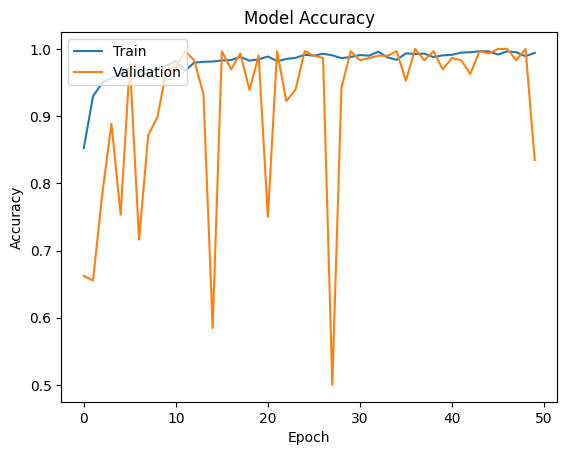

In [ ]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

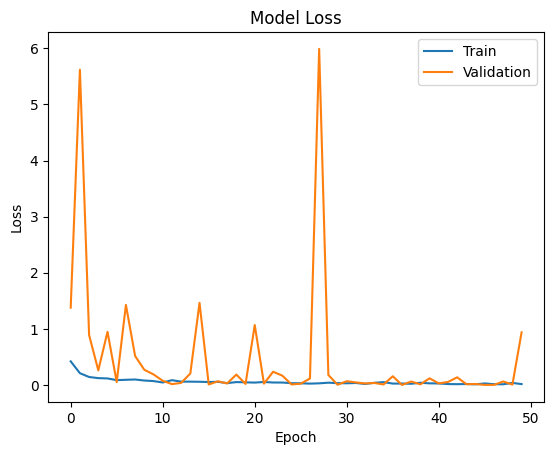

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

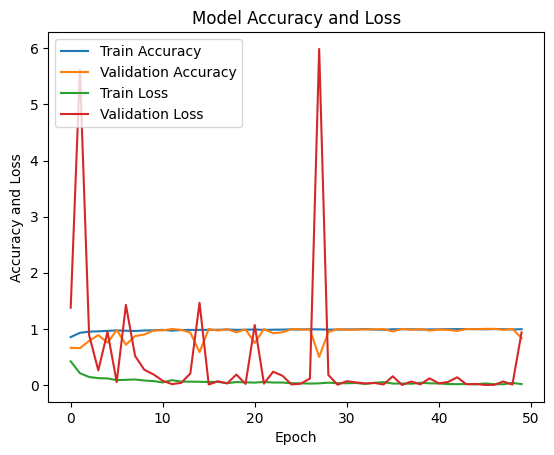

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

38/38 [==============================] - 6s 77ms/step - loss: 0.8131 - accuracy: 0.8520


[0.8525000214576721,
 0.9295833110809326,
 0.9495833516120911,
 0.956250011920929,
 0.9641666412353516,
 0.972083330154419,
 0.9662500023841858,
 0.9624999761581421,
 0.9708333611488342,
 0.9754166603088379,
 0.9820833206176758,
 0.9674999713897705,
 0.9795833230018616,
 0.9808333516120911,
 0.981249988079071,
 0.9829166531562805,
 0.9833333492279053,
 0.9883333444595337,
 0.9825000166893005,
 0.98458331823349,
 0.9887499809265137,
 0.9816666841506958,
 0.9850000143051147,
 0.9866666793823242,
 0.9912499785423279,
 0.9900000095367432,
 0.9929166436195374,
 0.9904166460037231,
 0.9862499833106995,
 0.9879166483879089,
 0.9908333420753479,
 0.9900000095367432,
 0.9958333373069763,
 0.987500011920929,
 0.9837499856948853,
 0.9933333396911621,
 0.9925000071525574,
 0.9929166436195374,
 0.9879166483879089,
 0.9904166460037231,
 0.9912499785423279,
 0.9945833086967468,
 0.9950000047683716,
 0.996666669845581,
 0.9962499737739563,
 0.9916666746139526,
 0.9962499737739563,
 0.9950000047683716,

In [ ]:
history.history['val_accuracy']

[0.662162184715271,
 0.6554054021835327,
 0.7837837934494019,
 0.8885135054588318,
 0.7533783912658691,
 0.9797297120094299,
 0.7162162065505981,
 0.8716216087341309,
 0.8986486196517944,
 0.9695945978164673,
 0.9729729890823364,
 0.9966216087341309,
 0.9831081032752991,
 0.9324324131011963,
 0.5844594836235046,
 0.9966216087341309,
 0.9695945978164673,
 0.9932432174682617,
 0.9391891956329346,
 0.9898648858070374,
 0.75,
 0.9966216087341309,
 0.9222972989082336,
 0.9391891956329346,
 0.9966216087341309,
 0.9898648858070374,
 0.9864864945411682,
 0.5,
 0.9425675868988037,
 0.9966216087341309,
 0.9831081032752991,
 0.9864864945411682,
 0.9898648858070374,
 0.9898648858070374,
 0.9966216087341309,
 0.9527027010917664,
 1.0,
 0.9831081032752991,
 0.9966216087341309,
 0.9695945978164673,
 0.9864864945411682,
 0.9831081032752991,
 0.962837815284729,
 0.9966216087341309,
 0.9932432174682617,
 1.0,
 1.0,
 0.9831081032752991,
 1.0,
 0.8344594836235046]

In [ ]:
history.history['loss']

[0.42102065682411194,
 0.20986883342266083,
 0.1419021040201187,
 0.1217980831861496,
 0.11647839844226837,
 0.08614037185907364,
 0.09212636202573776,
 0.09752510488033295,
 0.07915356010198593,
 0.06927228718996048,
 0.04448465257883072,
 0.0853700116276741,
 0.05959460511803627,
 0.05929373577237129,
 0.05692290514707565,
 0.05250081047415733,
 0.05644073337316513,
 0.032667167484760284,
 0.05133897811174393,
 0.04711786285042763,
 0.042273133993148804,
 0.05340447276830673,
 0.04383469372987747,
 0.04340093210339546,
 0.031538162380456924,
 0.029969628900289536,
 0.024110954254865646,
 0.02906748093664646,
 0.0406707338988781,
 0.03247181326150894,
 0.030196864157915115,
 0.035148438066244125,
 0.01782098226249218,
 0.038813266903162,
 0.05039666220545769,
 0.02468232810497284,
 0.025048207491636276,
 0.021557839587330818,
 0.03929561749100685,
 0.028989257290959358,
 0.027093689888715744,
 0.015894059091806412,
 0.014039264991879463,
 0.017168864607810974,
 0.011116649955511093,
 

In [ ]:
history.history['val_loss']

[1.37732994556427,
 5.617825031280518,
 0.8899633288383484,
 0.2598841190338135,
 0.9471960067749023,
 0.05155889689922333,
 1.426796555519104,
 0.5160043835639954,
 0.27068185806274414,
 0.18810488283634186,
 0.07490000128746033,
 0.01527042780071497,
 0.03678005561232567,
 0.20424215495586395,
 1.4637489318847656,
 0.008849883452057838,
 0.06532396376132965,
 0.027483150362968445,
 0.1853572577238083,
 0.0186031311750412,
 1.0677685737609863,
 0.023471122607588768,
 0.23607271909713745,
 0.16543880105018616,
 0.00941002368927002,
 0.022476335987448692,
 0.11560503393411636,
 5.988964557647705,
 0.17810270190238953,
 0.004536469932645559,
 0.06697766482830048,
 0.04526761919260025,
 0.026940027251839638,
 0.035546816885471344,
 0.0090022636577487,
 0.1550029069185257,
 0.0008132378570735455,
 0.061127785593271255,
 0.010823549702763557,
 0.11833613365888596,
 0.02786245197057724,
 0.05350283905863762,
 0.13640569150447845,
 0.012808534316718578,
 0.01724802516400814,
 0.00096335582202

In [ ]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.8519737124443054
Loss:  0.8131187558174133


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

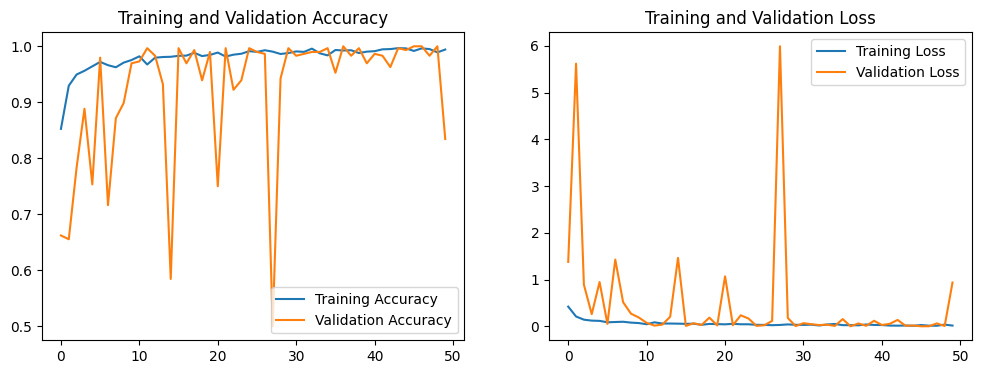

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___healthy
1/1 [==============================] - 3s 3s/step
[1.7324274e-09 9.0564658e-09 1.0000000e+00]
Max Value: 2
Predicted Label: Potato___healthy


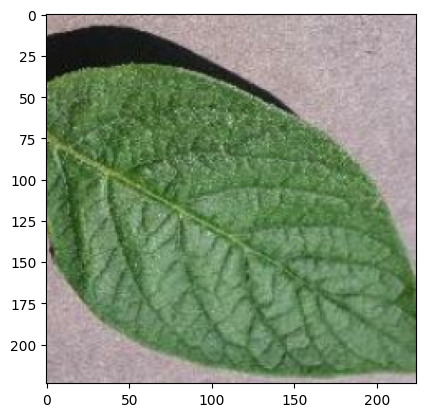

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


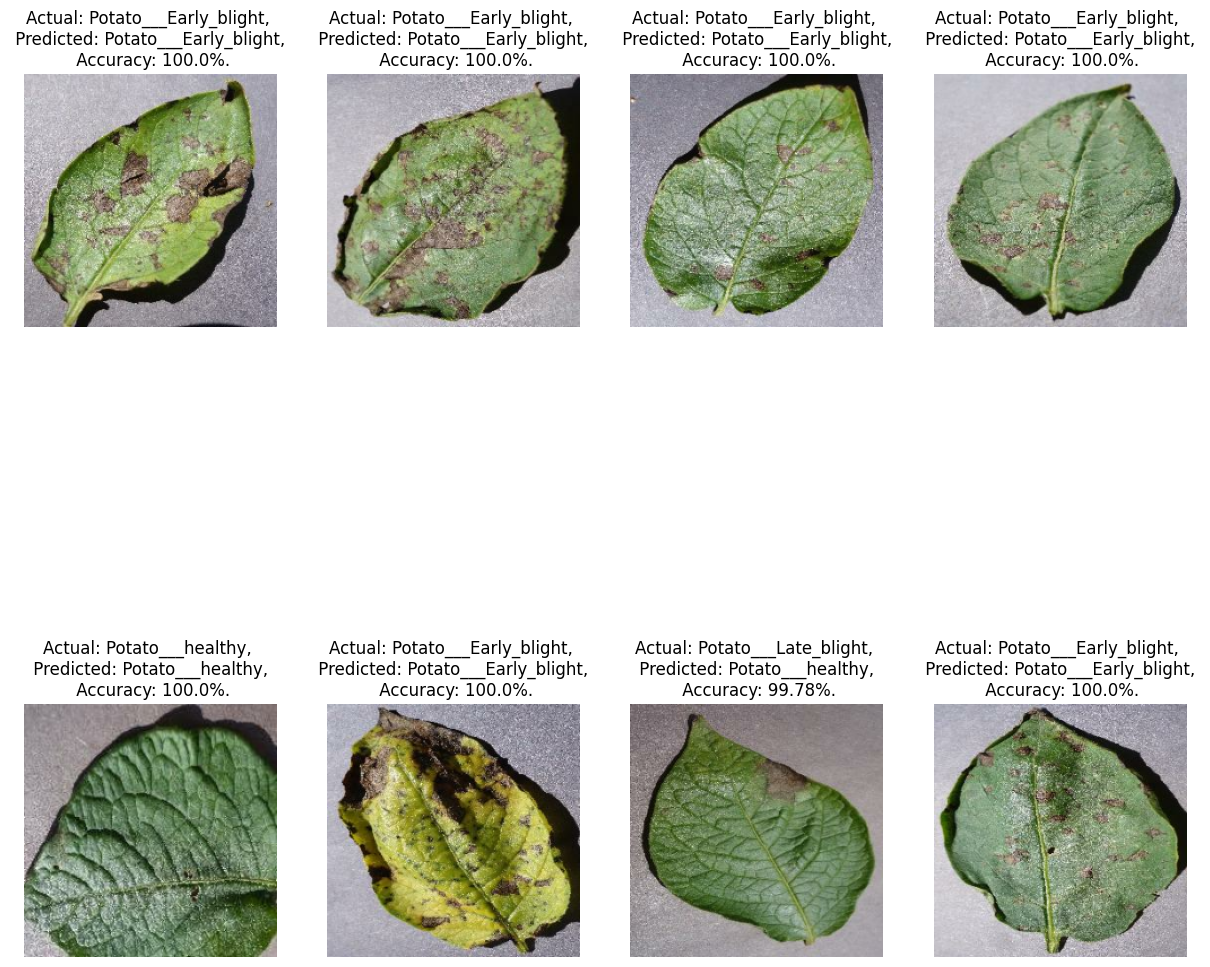

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [ ]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  85.19737124443054


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

38/38 [==============================] - 5s 71ms/step
F1 Score:  34.726233426978276
Precision Score:  35.75289002200259
Recall Score:  35.526315789473685


38/38 [==============================] - 2s 66ms/step


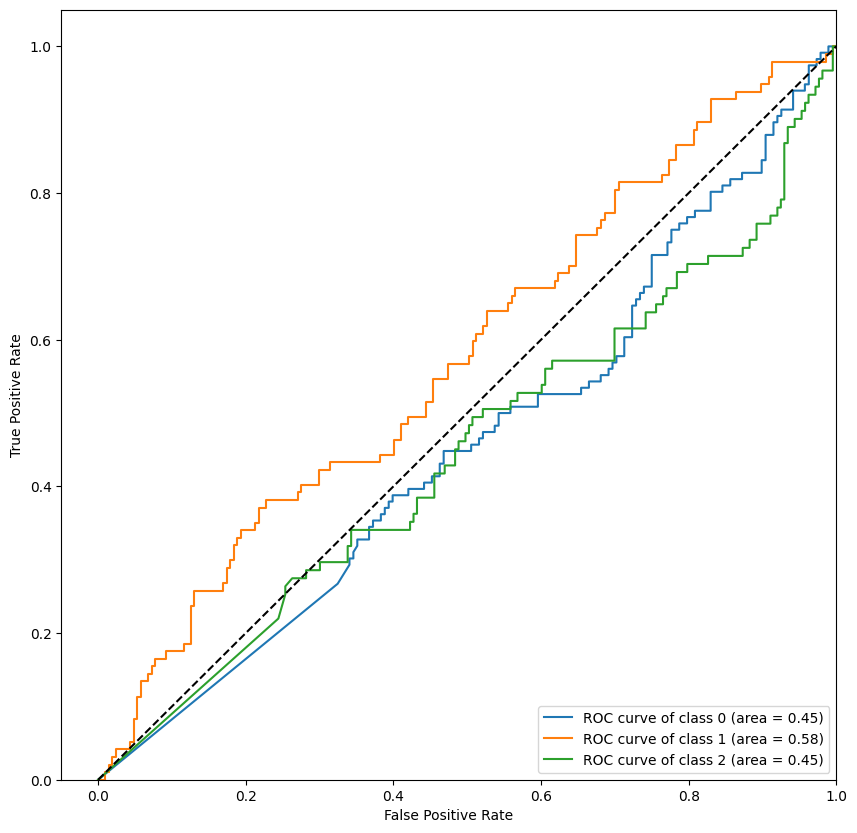

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

38/38 [==============================] - 2s 67ms/step


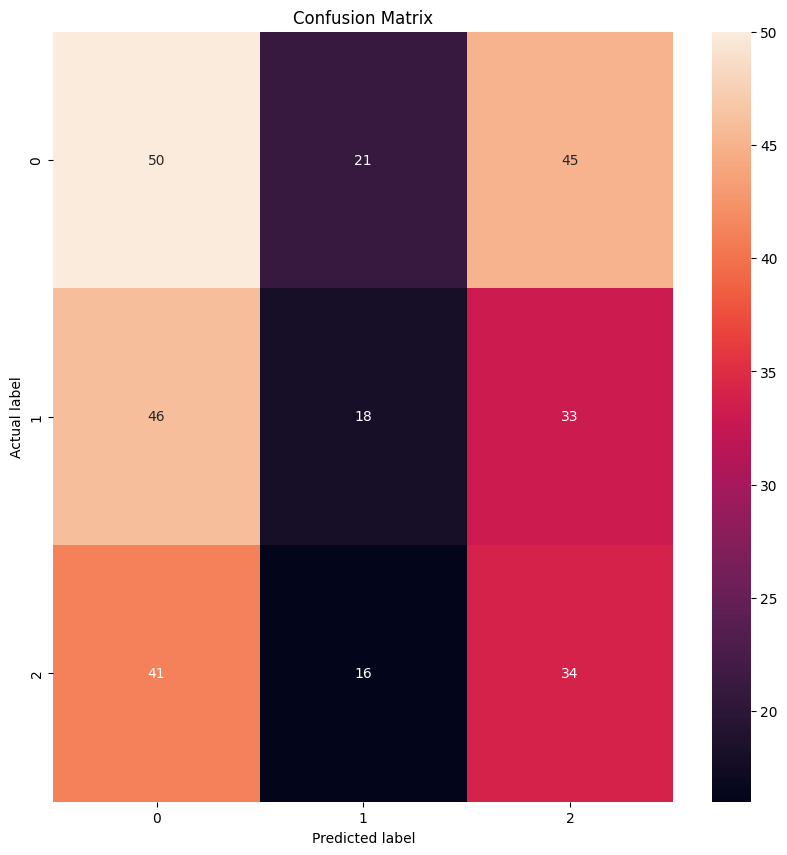

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()